In [10]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords, wordnet
import string
import re
import xgboost as xgb
import gc
from sklearn import preprocessing, metrics, ensemble, neighbors, linear_model, tree, model_selection
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import manifold, decomposition, naive_bayes
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from functools import lru_cache
from tqdm import tqdm as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from scipy import sparse

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df = train_df.fillna('unknown')
test_df = test_df.fillna('unknown')

In [4]:
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  95851
Number of rows in test dataset :  226998


In [5]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


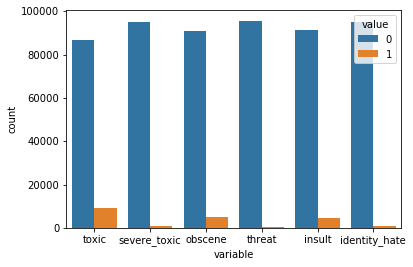

In [6]:
sns.countplot(x="variable", hue="value", data=pd.melt(train_df.iloc[:,2:8]))
plt.show()

In [16]:
train_df['comment_text'][1]

'Please do not vandalize page a you did with this edit to W S Merwin If you continue to do so you will be blocked from editing'

In [18]:
# function to clean the comment
# adapted from a kaggle kernal, can't find its link now
def cleanData(text):
    
    
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"[^A-Za-z]", " ", text)

    return text

In [19]:
%%time

train_df['comment_text'] = train_df['comment_text'].apply(lambda x: cleanData(x))
test_df['comment_text'] = test_df['comment_text'].apply(lambda x: cleanData(x))

CPU times: user 25.5 s, sys: 40 ms, total: 25.5 s
Wall time: 25.5 s


In [13]:
# define function for stemming and lemmatizing the text
def cleanData2(text, stemming = False, lemmatize=False):
    txt = str(text)
    txt = re.sub(r'-', r' ', txt)
    
   
    if stemming:
        st = EnglishStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    
    if lemmatize:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w) for w in txt.split()])
        
    return txt

In [14]:
%%time

train_df['comment_text'] = train_df['comment_text'].map(lambda x: cleanData2(x,  stemming = False, lemmatize=True))
test_df['comment_text'] = test_df['comment_text'].map(lambda x: cleanData2(x,  stemming = False, lemmatize=True))

In [16]:
train_df.to_csv('data/train_cleaned2.csv', index=False)
test_df.to_csv('data/test_cleaned2.csv', index=False)

In [22]:
print("severe_toxic:")
print((train_df[train_df.severe_toxic==1].iloc[4,1]).strip())

severe_toxic:
fuck                                                                                     fuck you bitch screw you harry potter asshole licking
